# Ultimate Tech Challenge

<!--![chicago](images/chiskyline.png)

reference: [Kaggle Challenge 2015](https://www.kaggle.com/c/predict-west-nile-virus)
-->

# Import packages and define functions

In [102]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import datetime 

from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold, GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, f1_score, roc_curve, roc_auc_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import pickle 

import shap

#import plotly

%matplotlib inline 

sns.set_style('ticks', rc={'xtick.direction':'in', 'ytick.direction':'in', \
                           'xtick.top':True, 'ytick.right':True})

# Load Datasets

In [2]:
datadir    = '../datasets/raw'
datadir_pr = '../datasets/processed'  # directory where the cleaned datasets are stored
figdir     = '../output/figures'

# Part1 - Exploratory Data Analysis

The attached logins.json file contains (simulated) timestamps of user logins in a particular geographic location. Aggregate these login counts based on 15minute
time intervals, and visualize and describe the resulting time series of login counts in ways that best characterize the underlying patterns of the demand. Please report/illustrate important features of the demand, such as daily cycles. If there are data quality issues, please report them.

## Data load and wrangling

In [3]:
''' read the dataset '''

df_log = pd.read_json(os.path.join(datadir, 'logins.json'))

In [4]:
df_log.head()

,login_time
0,1970-01-01 20:13:18
1,1970-01-01 20:16:10
2,1970-01-01 20:16:37
3,1970-01-01 20:16:36
4,1970-01-01 20:26:21


In [5]:
df_log.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93142 entries, 0 to 93141
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   login_time  93142 non-null  datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 727.8 KB


In [6]:
df_log.isnull().sum()

login_time    0
dtype: int64

> There is no null data!

In [7]:
''' add column: counts '''
df_log['Counts'] = 1

In [8]:
''' set index '''

df_log.set_index('login_time', inplace=True)
df_log.head()

,Counts
login_time,
1970-01-01 20:13:18,1
1970-01-01 20:16:10,1
1970-01-01 20:16:37,1
1970-01-01 20:16:36,1
1970-01-01 20:26:21,1


In [9]:
''' aggregate the login counts based on 15minutes time intervals '''

df_log15 = df_log.resample('15T').sum()
df_log15.head()

,Counts
login_time,
1970-01-01 20:00:00,2
1970-01-01 20:15:00,6
1970-01-01 20:30:00,9
1970-01-01 20:45:00,7
1970-01-01 21:00:00,1


In [10]:
df_log15.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 9788 entries, 1970-01-01 20:00:00 to 1970-04-13 18:45:00
Freq: 15T
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   Counts  9788 non-null   int64
dtypes: int64(1)
memory usage: 152.9 KB


> No null values!

In [11]:
df_log15['Month'] = df_log15.index.month
df_log15['Day'] = df_log15.index.day
df_log15['Week_year'] = df_log15.index.isocalendar().week
df_log15['Weekday'] = df_log15.index.weekday
df_log15['Weekend'] = ((df_log15.index.weekday) // 5 == 1).astype(int)
df_log15['Hour'] = df_log15.index.hour

In [12]:
df_log15

,Counts,Month,Day,Week_year,Weekday,Weekend,Hour
login_time,,,,,,,
1970-01-01 20:00:00,2,1,1,1,3,0,20
1970-01-01 20:15:00,6,1,1,1,3,0,20
1970-01-01 20:30:00,9,1,1,1,3,0,20
1970-01-01 20:45:00,7,1,1,1,3,0,20
1970-01-01 21:00:00,1,1,1,1,3,0,21
...,...,...,...,...,...,...,...
1970-04-13 17:45:00,5,4,13,16,0,0,17
1970-04-13 18:00:00,5,4,13,16,0,0,18
1970-04-13 18:15:00,2,4,13,16,0,0,18


## Login activities by periods

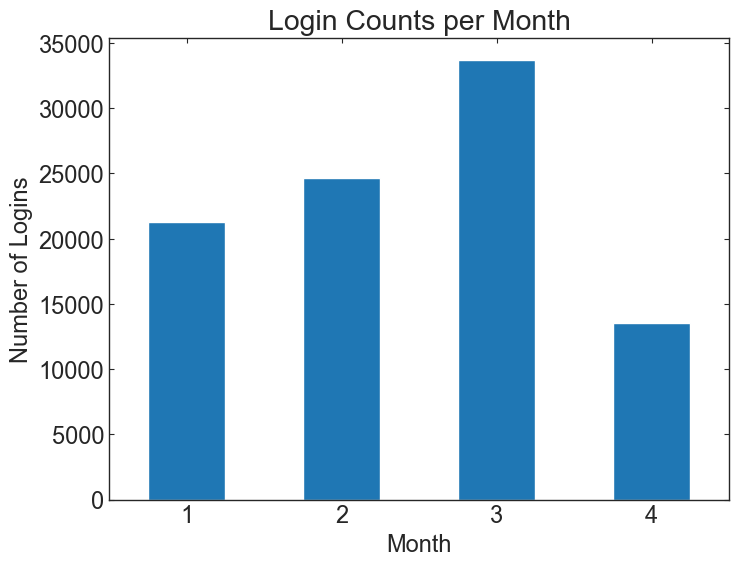

In [13]:
''' login activities by months '''

fig, ax = plt.subplots()
df_log15.groupby('Month').Counts.sum().plot(kind='bar', ax=ax)

ax.tick_params(axis='x', rotation=0)
ax.set(title='Login Counts per Month', ylabel='Number of Logins');

> Login is the most active in March, showing the monotonous increase from January. Login activity drops to 13k, but it is because it contains the data only for 13 days.

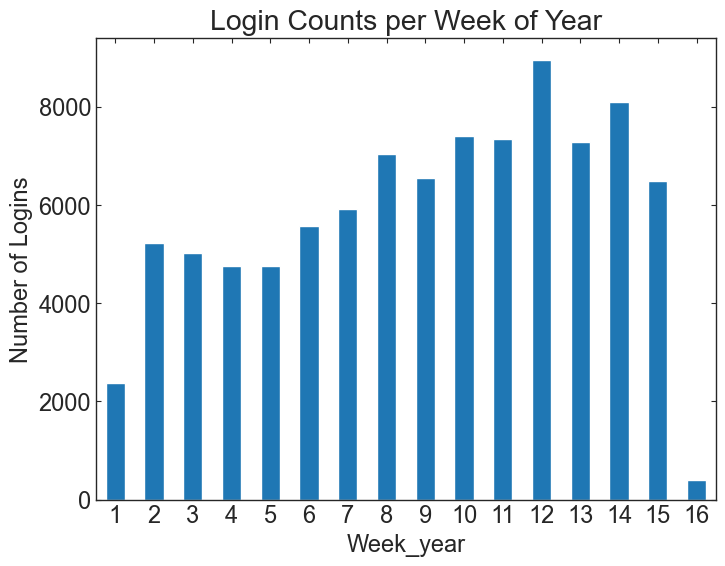

In [14]:
''' login activities by week of year '''

fig, ax = plt.subplots()
df_log15.groupby('Week_year').Counts.sum().plot(kind='bar', ax=ax)

ax.tick_params(axis='x', rotation=0)
ax.set(title='Login Counts per Week of Year', ylabel='Number of Logins');

> Logins are the most active in 12th week, which is the last week of March. Overall, login activities are increasing to 8th week, after which it shows plateau. 

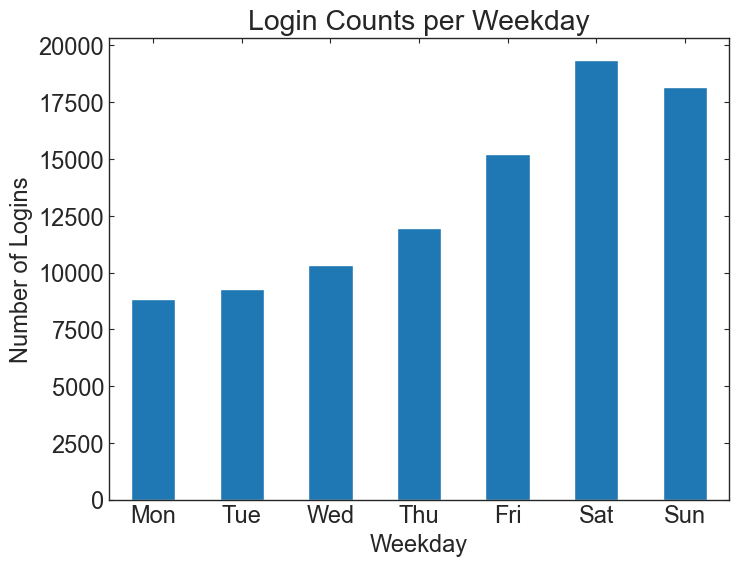

In [15]:
''' login activities by weekdays '''

# xtick format function 
week_name = {0:'Mon', 1:'Tue', 2:'Wed', 3:'Thu', 4:'Fri', 5:'Sat', 6:'Sun'}
#ticklabel_func = lambda value, tick_number: week_name[value]

fig, ax = plt.subplots()
df_log15.groupby('Weekday').Counts.sum().plot(kind='bar', ax=ax)
ax.tick_params(axis='x', rotation=0)

#ax.xaxis.set_major_formatter(plt.FuncFormatter(ticklabel_func))
ax.set_xticklabels([week_name[d] for d in range(len(week_name))])
ax.set(title='Login Counts per Weekday', ylabel='Number of Logins');

> Login activities keep increasing from Monday to Saturday. 

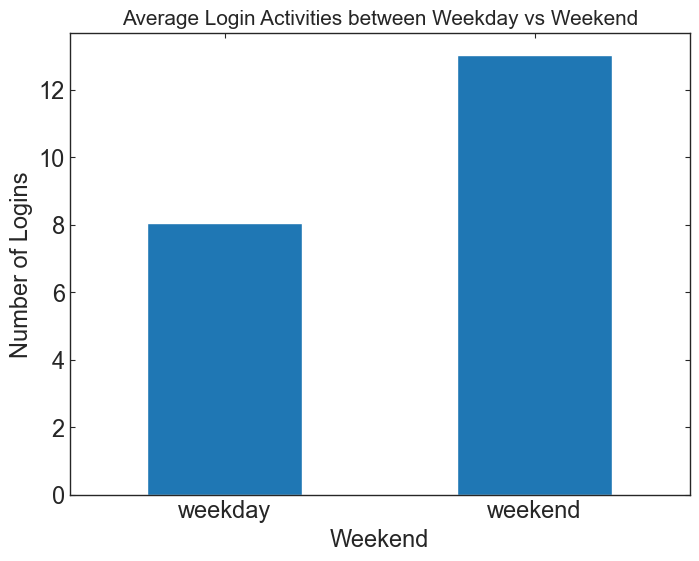

In [16]:
''' average login activities between weekday vs. weekend '''

# xtick format function 
weekend_name = {0:'weekday', 1:'weekend'}

fig, ax = plt.subplots()
df_log15.groupby('Weekend').Counts.mean().plot(kind='bar', ax=ax)
ax.tick_params(axis='x', rotation=0)

ax.set_xticklabels([weekend_name[d] for d in range(len(weekend_name))])
ax.set_title('Average Login Activities between Weekday vs Weekend', fontsize=15) 
ax.set_ylabel('Number of Logins');

> Logins are more active in weekend than in weekdays.

In [17]:
# resample to the frequency of day
df_logD = df_log.resample('D').sum()
df_logD['Weekday'] = df_logD.index.weekday

df_logD.head()

,Counts,Weekday
login_time,,
1970-01-01,112,3
1970-01-02,681,4
1970-01-03,793,5
1970-01-04,788,6
1970-01-05,459,0


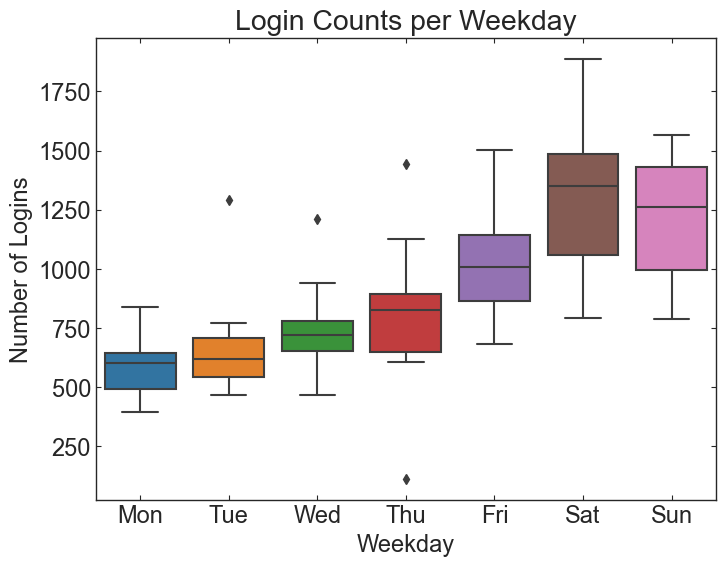

In [18]:
fig, ax = plt.subplots()

week_name = {0:'Mon', 1:'Tue', 2:'Wed', 3:'Thu', 4:'Fri', 5:'Sat', 6:'Sun'}

sns.boxplot(x='Weekday', y='Counts', data=df_logD, ax=ax)

ax.set_xticklabels([week_name[d] for d in range(7)])
ax.set(title='Login Counts per Weekday', ylabel='Number of Logins');

> Similarly, the total number of logins is increasing from Monday to Saturday. One notable thing is that there are outliers on Tuesday, Wednesday, and Thursday, and the variation is the most on Saturday. 

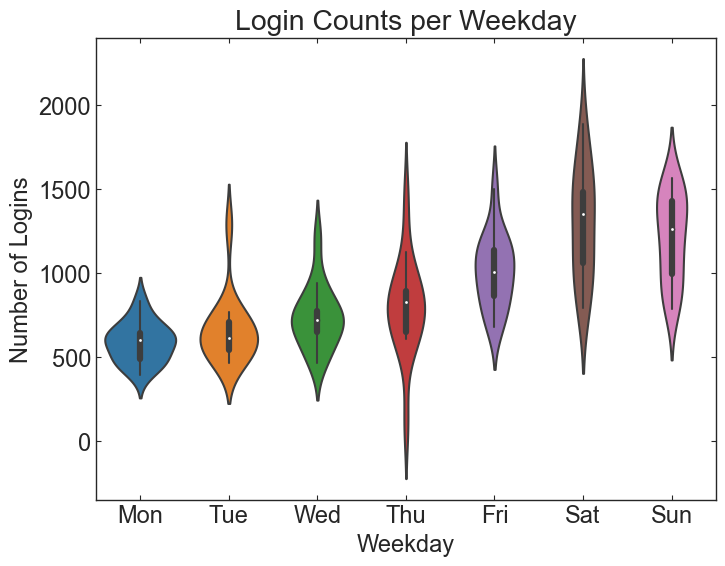

In [19]:
fig, ax = plt.subplots()

week_name = {0:'Mon', 1:'Tue', 2:'Wed', 3:'Thu', 4:'Fri', 5:'Sat', 6:'Sun'}

sns.violinplot(x='Weekday', y='Counts', data=df_logD, ax=ax)

ax.set_xticklabels([week_name[d] for d in range(7)])
ax.set(title='Login Counts per Weekday', ylabel='Number of Logins');

### Login activities in daily cycle

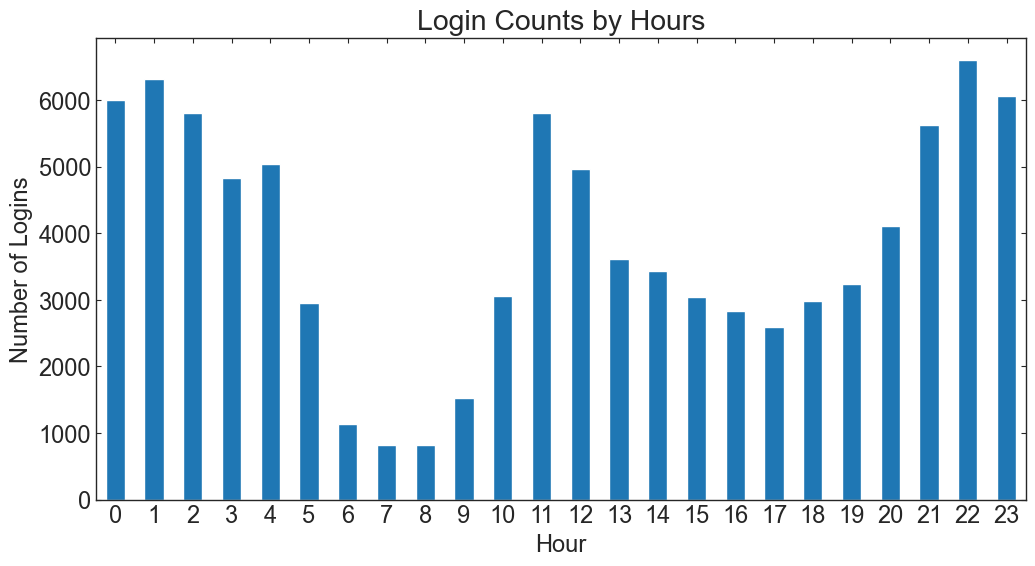

In [20]:
''' login activities by week of year '''

fig, ax = plt.subplots(figsize=(12,6))
df_log15.groupby('Hour').Counts.sum().plot(kind='bar', ax=ax)

ax.tick_params(axis='x', rotation=0)
ax.set(title='Login Counts by Hours', ylabel='Number of Logins');

> Logins are the least active in the morning, and there are the highest logins at 11am - noon and 9pm - 1am. 

In [21]:
# resample to the frequency of 1 hour
df_logH = df_log.resample('H').sum()
df_logH['Hour'] = df_logH.index.hour

df_logH.head()

,Counts,Hour
login_time,,
1970-01-01 20:00:00,24,20
1970-01-01 21:00:00,9,21
1970-01-01 22:00:00,21,22
1970-01-01 23:00:00,58,23
1970-01-02 00:00:00,53,0


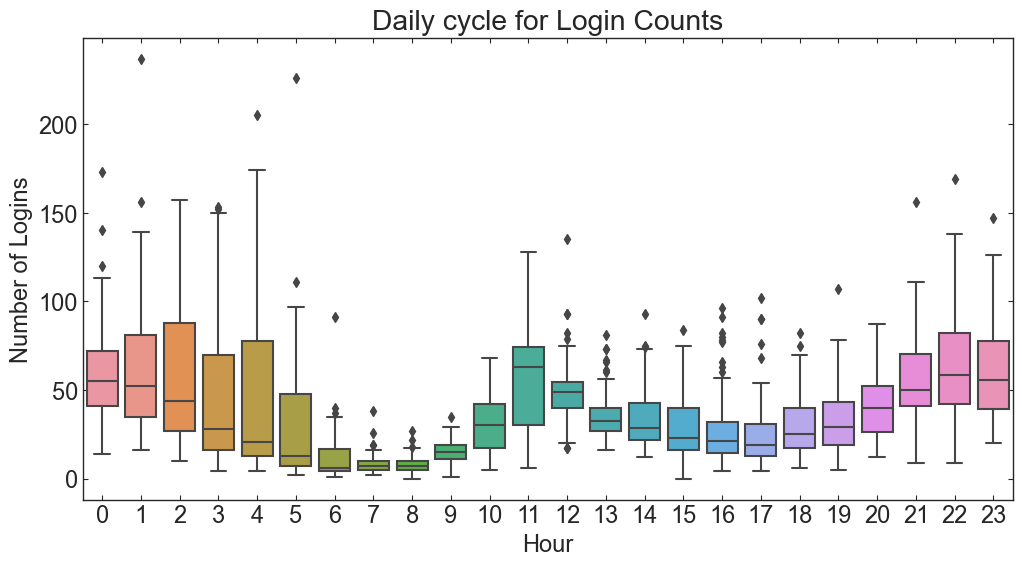

In [22]:
fig, ax = plt.subplots(figsize=(12,6))

sns.boxplot(x='Hour', y='Counts', data=df_logH, ax=ax)

ax.set(title='Daily cycle for Login Counts', ylabel='Number of Logins');

> There are significant variation between 2am and 4am, and the smallest variation in the morning with the smallest logins.

# Part2 - Experiment and metrics design

The neighboring cities of Gotham and Metropolis have complementary circadian rhythms: on weekdays, Ultimate Gotham is most active at night, and Ultimate Metropolis is most active during the day. On weekends, there is reasonable activity in both cities.

However, a toll bridge, with a two way toll, between the two cities causes driver partners to tend to be exclusive to each city. The Ultimate managers of city operations for the two cities have proposed an experiment to encourage driver partners to be available in both cities, by reimbursing all toll costs.

1) What would you choose as the key measure of success of this experiment in encouraging driver partners to serve both cities, and why would you choose this metric?
2) Describe a practical experiment you would design to compare the effectiveness of the proposed change in relation to the key measure of success. Please provide details on:
    a) how you will implement the experiment
    b) what statistical test(s) you will conduct to verify the significance of the observation 
    c) how you would interpret the results and provide recommendations to the city operations team along with any caveats.
    
**Note: The two cities of Gotham and Metropolis are not in the provided dataset; however, you do not need this information to answer Part 2.**

> Answer 1: I would choose the total amount of toll  costs that were reimbursed as the key measure of success for this experiment. If the costs increase, it indicates that more driver passed the toll bridge.

> Answer 2: 
> I will design the experiment by colleecting the data that includes the toll costs, date, time, weekdays (or holidays), direction. The data should have the ones both before and after the moment when the toll is reimbursed. I will analyze and visualize the trend, and will provide recommendations to the city.

# Part3 - Predictive Modeling

Ultimate is interested in predicting rider retention. To help explore this question, we have provided a sample dataset of a cohort of users who signed up for an Ultimate account in January 2014. The data was pulled several months later; we consider a user retained if they were “active” (i.e. took a trip) in the preceding 30 days.

We would like you to use this data set to help understand **what factors are the best predictors for retention**, and offer suggestions to operationalize those insights to help Ultimate. 

The data is in the attached file ultimate_data_challenge.json. See below for a detailed description of the dataset. Please include any code you wrote for the analysis and delete the dataset when you have finished with the challenge.

1. Perform any cleaning, exploratory analysis, and/or visualizations to use the provided data for this analysis (a few sentences/plots describing your approach will suffice). What fraction of the observed users were retained?
2. Build a predictive model to help Ultimate determine whether or not a user will be active in their 6th month on the system. Discuss why you chose your approach, what alternatives you considered, and any concerns you have. How valid is your model? Include any key indicators of model performance.
3. Briefly discuss how Ultimate might leverage the insights gained from the model to improve its long term rider retention (again, a few sentences will suffice).

## Data description 
- phone: primary device for this user
- signup_date: date of account registration; in the form ‘YYYYMMDD’
- last_trip_date: the last time this user completed a trip; in the form ‘YYYYMMDD’
- avg_dist: the average distance in miles per trip taken in the first 30 days after signup
- avg_rating_by_driver: the rider’s average rating over all of their trips
- avg_rating_of_driver: the rider’s average rating of their drivers over all of their trips
- surge_pct: the percent of trips taken with surge multiplier > 1
- avg_surge: The average surge multiplier over all of this user’s trips
- trips_in_first_30_days: the number of trips this user took in the first 30 days after signing up
- ultimate_black_user: TRUE if the user took an Ultimate Black in their first 30 days; FALSE
otherwise
- weekday_pct: the percent of the user’s trips occurring during a weekday

## Data Loading & Wrangling

In [23]:
''' read the dataset '''

df_ride = pd.read_json(os.path.join(datadir, 'ultimate_data_challenge.json'))

In [24]:
df_ride.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9


In [25]:
df_ride.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   city                    50000 non-null  object 
 1   trips_in_first_30_days  50000 non-null  int64  
 2   signup_date             50000 non-null  object 
 3   avg_rating_of_driver    41878 non-null  float64
 4   avg_surge               50000 non-null  float64
 5   last_trip_date          50000 non-null  object 
 6   phone                   49604 non-null  object 
 7   surge_pct               50000 non-null  float64
 8   ultimate_black_user     50000 non-null  bool   
 9   weekday_pct             50000 non-null  float64
 10  avg_dist                50000 non-null  float64
 11  avg_rating_by_driver    49799 non-null  float64
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 4.2+ MB


In [26]:
df_ride.isnull().sum()

city                         0
trips_in_first_30_days       0
signup_date                  0
avg_rating_of_driver      8122
avg_surge                    0
last_trip_date               0
phone                      396
surge_pct                    0
ultimate_black_user          0
weekday_pct                  0
avg_dist                     0
avg_rating_by_driver       201
dtype: int64

> Missing values exist in `avg_rating_of_driver`, `phone`, and `avg_rating_by_driver`.

In [27]:
''' fill avg_rating_of_driver & avg_rating_by_driver w/ median values '''

df_ride.avg_rating_of_driver.fillna(df_ride.avg_rating_of_driver.median(), inplace=True)
df_ride.avg_rating_by_driver.fillna(df_ride.avg_rating_by_driver.median(), inplace=True)

In [28]:
''' drop Null value in phone '''

df_ride.dropna(axis=0, inplace=True)

In [29]:
df_ride.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 49604 entries, 0 to 49999
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   city                    49604 non-null  object 
 1   trips_in_first_30_days  49604 non-null  int64  
 2   signup_date             49604 non-null  object 
 3   avg_rating_of_driver    49604 non-null  float64
 4   avg_surge               49604 non-null  float64
 5   last_trip_date          49604 non-null  object 
 6   phone                   49604 non-null  object 
 7   surge_pct               49604 non-null  float64
 8   ultimate_black_user     49604 non-null  bool   
 9   weekday_pct             49604 non-null  float64
 10  avg_dist                49604 non-null  float64
 11  avg_rating_by_driver    49604 non-null  float64
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 4.6+ MB


In [30]:
''' convert date features to datetime format '''

df_ride.signup_date = pd.to_datetime(df_ride.signup_date)
df_ride.last_trip_date = pd.to_datetime(df_ride.last_trip_date)

In [31]:
df_ride.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 49604 entries, 0 to 49999
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   city                    49604 non-null  object        
 1   trips_in_first_30_days  49604 non-null  int64         
 2   signup_date             49604 non-null  datetime64[ns]
 3   avg_rating_of_driver    49604 non-null  float64       
 4   avg_surge               49604 non-null  float64       
 5   last_trip_date          49604 non-null  datetime64[ns]
 6   phone                   49604 non-null  object        
 7   surge_pct               49604 non-null  float64       
 8   ultimate_black_user     49604 non-null  bool          
 9   weekday_pct             49604 non-null  float64       
 10  avg_dist                49604 non-null  float64       
 11  avg_rating_by_driver    49604 non-null  float64       
dtypes: bool(1), datetime64[ns](2), float64(6), int

In [32]:
df_ride.sample(5)

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
37715,Winterfell,1,2014-01-14,5.0,1.50,2014-01-17,iPhone,100.0,False,100.0,17.65,5.0
46906,Winterfell,0,2014-01-10,4.0,1.00,2014-06-16,iPhone,0.0,False,33.3,7.64,5.0
49459,King's Landing,0,2014-01-18,5.0,1.25,2014-06-21,iPhone,25.0,False,25.0,1.58,4.5
6444,Winterfell,1,2014-01-09,5.0,1.00,2014-01-28,iPhone,0.0,False,100.0,2.99,5.0
30394,Winterfell,0,2014-01-07,4.9,1.00,2014-02-16,iPhone,0.0,False,0.0,0.98,5.0


## Exploratory Data Analysis

### Number counts for city, phone, and ultimate_black_user

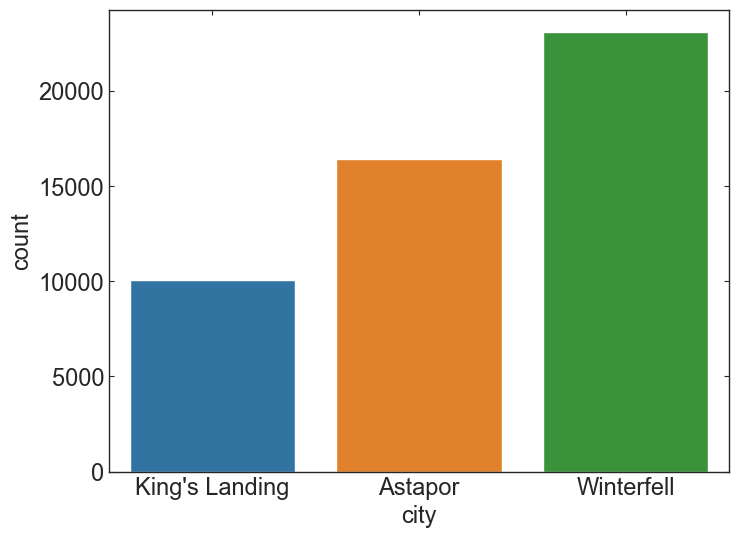

In [33]:
fig, ax = plt.subplots()
sns.countplot(x='city', data=df_ride, ax=ax);

> Number of riders is the largest in the city of Winterfell and the smallest in the city of King's Landing.

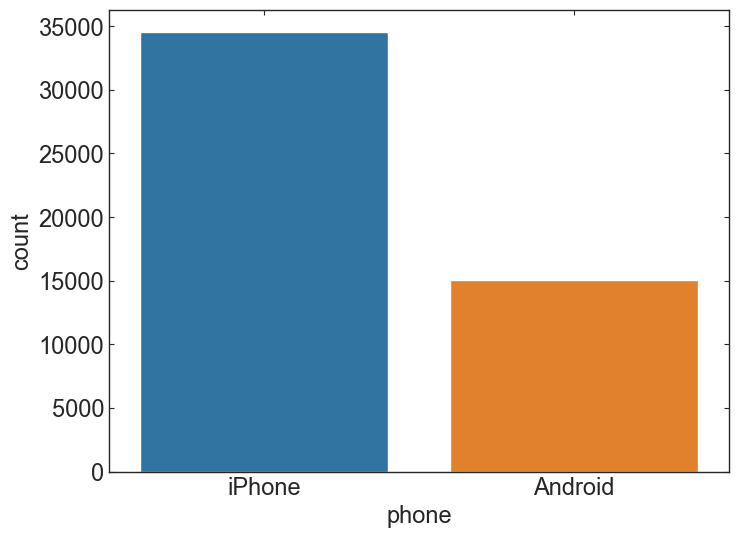

In [34]:
fig, ax = plt.subplots()
sns.countplot(x='phone', data=df_ride, ax=ax);

> For the riders, iPhone users are more than Android users. 

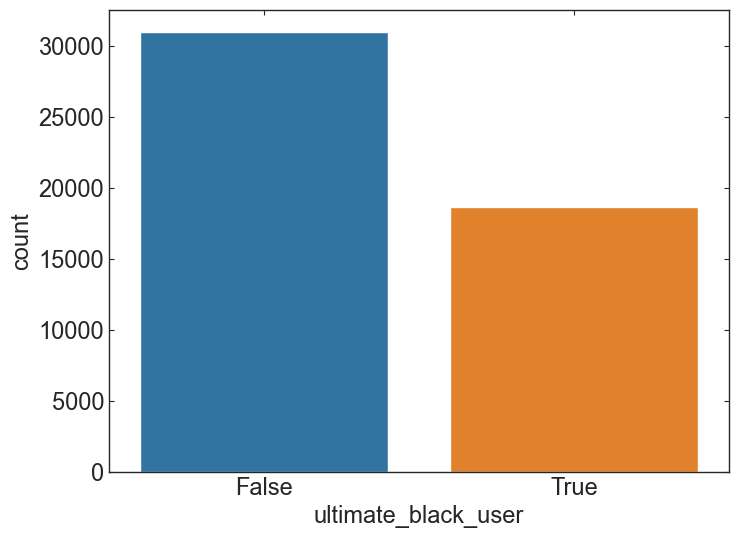

In [35]:
fig, ax = plt.subplots()
sns.countplot(x='ultimate_black_user', data=df_ride, ax=ax);

### Histograms for the dataset

In [36]:
df_ride.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 49604 entries, 0 to 49999
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   city                    49604 non-null  object        
 1   trips_in_first_30_days  49604 non-null  int64         
 2   signup_date             49604 non-null  datetime64[ns]
 3   avg_rating_of_driver    49604 non-null  float64       
 4   avg_surge               49604 non-null  float64       
 5   last_trip_date          49604 non-null  datetime64[ns]
 6   phone                   49604 non-null  object        
 7   surge_pct               49604 non-null  float64       
 8   ultimate_black_user     49604 non-null  bool          
 9   weekday_pct             49604 non-null  float64       
 10  avg_dist                49604 non-null  float64       
 11  avg_rating_by_driver    49604 non-null  float64       
dtypes: bool(1), datetime64[ns](2), float64(6), int

In [37]:
# column names for the numeric features
col_numeric = df_ride.select_dtypes(include=np.number).columns

print(col_numeric)

Index(['trips_in_first_30_days', 'avg_rating_of_driver', 'avg_surge',
       'surge_pct', 'weekday_pct', 'avg_dist', 'avg_rating_by_driver'],
      dtype='object')


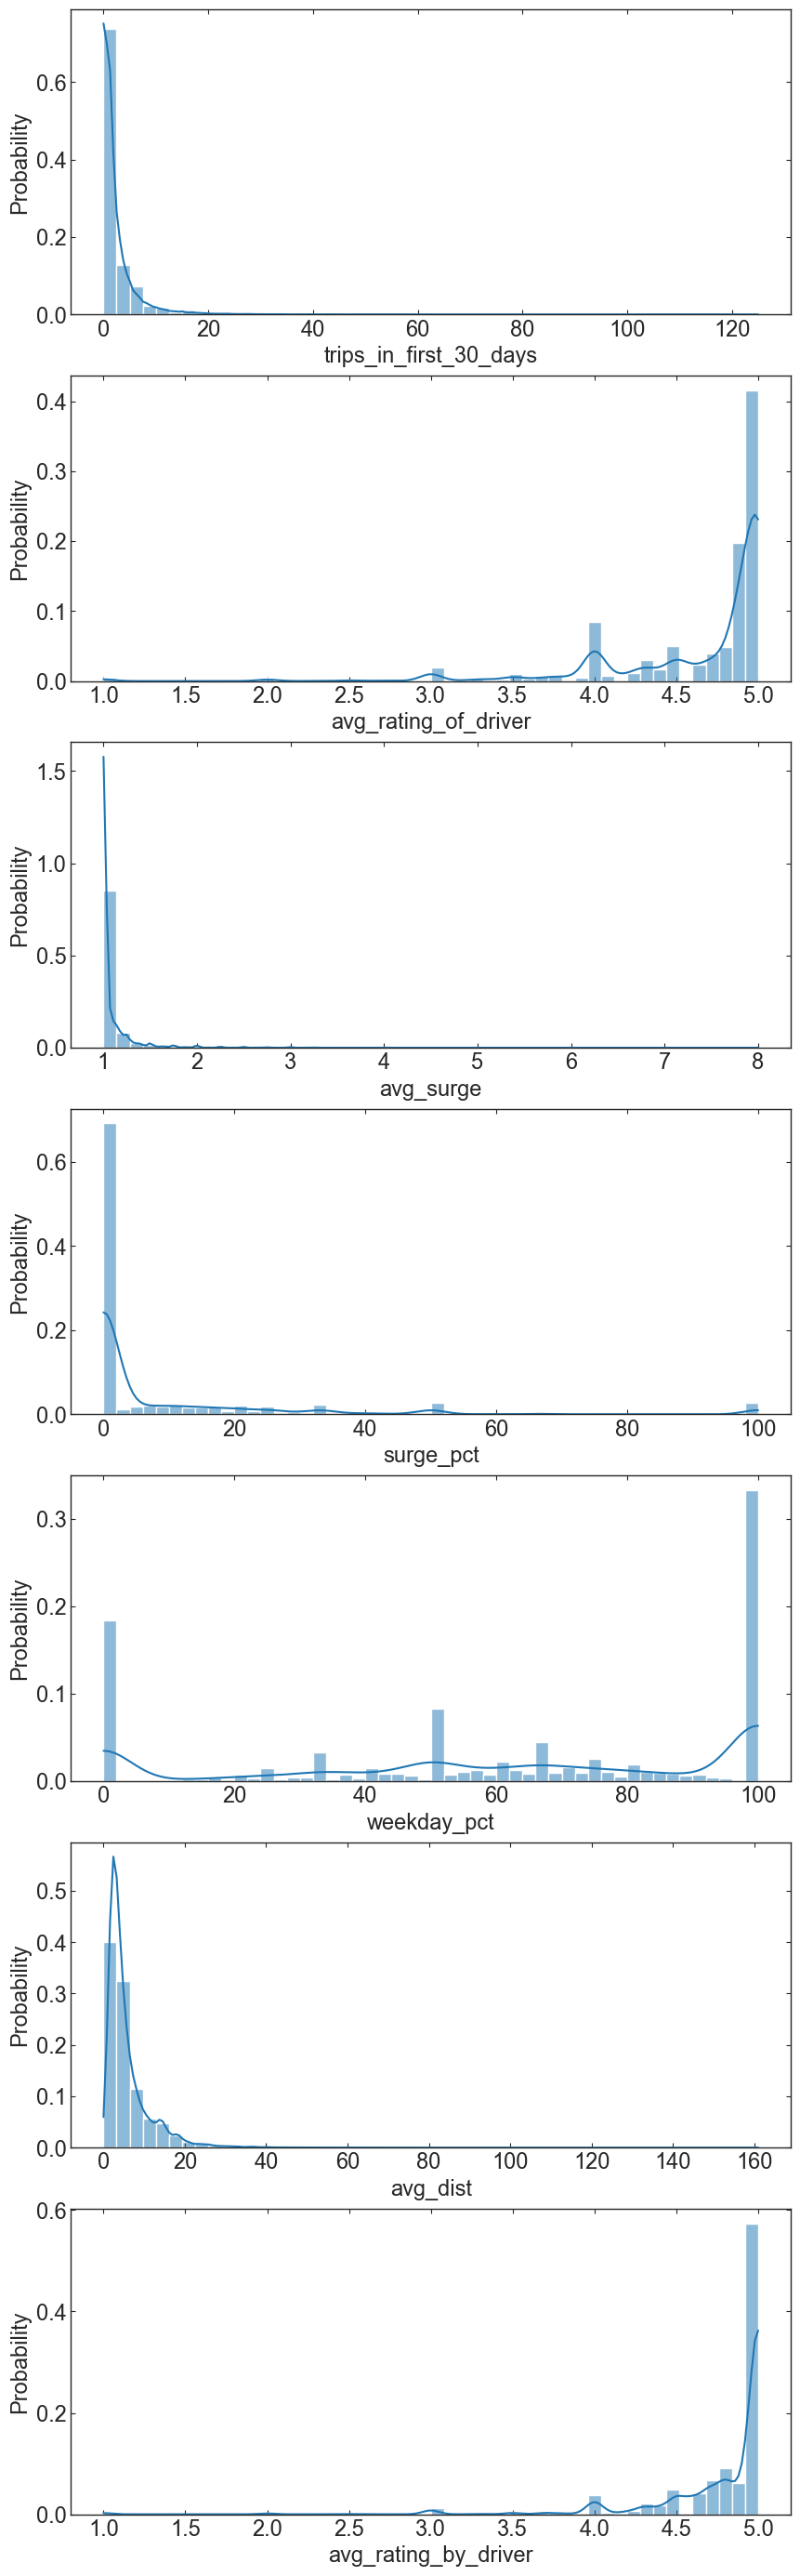

In [38]:
ncols = len(col_numeric)
fig, axes = plt.subplots(ncols,1, figsize=(10,35))

for i, iax in enumerate(axes.flat):
    sns.histplot(x=col_numeric[i], data=df_ride, kde=True, \
                 stat='probability', bins=50, ax=iax);

### Retained riders

In [39]:
print(df_ride.last_trip_date.max())

2014-07-01 00:00:00


> The criteria for the retaining status is being active in the preceding 30 days. Since the latest date information is July 1st, 2014, we can consider a user as a retained one if his/her last_trip_date is after June 1st, 2014. 

In [40]:
df_ride['retained'] = df_ride.last_trip_date.apply(lambda x: 1 if x > pd.to_datetime('2014-06-01') else 0)

In [41]:
df_ride[['last_trip_date','retained']].sample(10)

,last_trip_date,retained
39839,2014-06-05,1
11952,2014-03-23,0
42011,2014-01-15,0
42849,2014-06-26,1
33441,2014-05-20,0
16352,2014-05-31,0
30268,2014-06-29,1
40305,2014-01-10,0
39213,2014-02-28,0
43444,2014-02-09,0


In [42]:
retained_rate = df_ride.retained.mean()

print('percentage of the retained users: {:.2f}%'.format(retained_rate*100))

percentage of the retained users: 36.65%


## Feature Engineering

In [43]:
''' drop datetime features '''
df = df_ride.select_dtypes(exclude='datetime64')

In [44]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 49604 entries, 0 to 49999
Data columns (total 11 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   city                    49604 non-null  object 
 1   trips_in_first_30_days  49604 non-null  int64  
 2   avg_rating_of_driver    49604 non-null  float64
 3   avg_surge               49604 non-null  float64
 4   phone                   49604 non-null  object 
 5   surge_pct               49604 non-null  float64
 6   ultimate_black_user     49604 non-null  bool   
 7   weekday_pct             49604 non-null  float64
 8   avg_dist                49604 non-null  float64
 9   avg_rating_by_driver    49604 non-null  float64
 10  retained                49604 non-null  int64  
dtypes: bool(1), float64(6), int64(2), object(2)
memory usage: 4.2+ MB


In [45]:
df.head()

,city,trips_in_first_30_days,avg_rating_of_driver,avg_surge,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,retained
0,King's Landing,4,4.7,1.10,iPhone,15.4,True,46.2,3.67,5.0,1
1,Astapor,0,5.0,1.00,Android,0.0,False,50.0,8.26,5.0,0
2,Astapor,3,4.3,1.00,iPhone,0.0,False,100.0,0.77,5.0,0
3,King's Landing,9,4.6,1.14,iPhone,20.0,True,80.0,2.36,4.9,1
4,Winterfell,14,4.4,1.19,Android,11.8,False,82.4,3.13,4.9,0


In [46]:
''' ultimate_black_user type conversion from bool to integer '''

df.ultimate_black_user.replace({True:1, False:0}, inplace=True)

In [47]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 49604 entries, 0 to 49999
Data columns (total 11 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   city                    49604 non-null  object 
 1   trips_in_first_30_days  49604 non-null  int64  
 2   avg_rating_of_driver    49604 non-null  float64
 3   avg_surge               49604 non-null  float64
 4   phone                   49604 non-null  object 
 5   surge_pct               49604 non-null  float64
 6   ultimate_black_user     49604 non-null  int64  
 7   weekday_pct             49604 non-null  float64
 8   avg_dist                49604 non-null  float64
 9   avg_rating_by_driver    49604 non-null  float64
 10  retained                49604 non-null  int64  
dtypes: float64(6), int64(3), object(2)
memory usage: 4.5+ MB


In [48]:
df.head()

,city,trips_in_first_30_days,avg_rating_of_driver,avg_surge,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,retained
0,King's Landing,4,4.7,1.10,iPhone,15.4,1,46.2,3.67,5.0,1
1,Astapor,0,5.0,1.00,Android,0.0,0,50.0,8.26,5.0,0
2,Astapor,3,4.3,1.00,iPhone,0.0,0,100.0,0.77,5.0,0
3,King's Landing,9,4.6,1.14,iPhone,20.0,1,80.0,2.36,4.9,1
4,Winterfell,14,4.4,1.19,Android,11.8,0,82.4,3.13,4.9,0


### one-hot encoding for categorical features
- city and phone

In [49]:
df = pd.get_dummies(df, columns=['city', 'phone'], drop_first=True)

In [50]:
df.head()

,trips_in_first_30_days,avg_rating_of_driver,avg_surge,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,retained,city_King's Landing,city_Winterfell,phone_iPhone
0,4,4.7,1.10,15.4,1,46.2,3.67,5.0,1,1,0,1
1,0,5.0,1.00,0.0,0,50.0,8.26,5.0,0,0,0,0
2,3,4.3,1.00,0.0,0,100.0,0.77,5.0,0,0,0,1
3,9,4.6,1.14,20.0,1,80.0,2.36,4.9,1,1,0,1
4,14,4.4,1.19,11.8,0,82.4,3.13,4.9,0,0,1,0


In [51]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 49604 entries, 0 to 49999
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   trips_in_first_30_days  49604 non-null  int64  
 1   avg_rating_of_driver    49604 non-null  float64
 2   avg_surge               49604 non-null  float64
 3   surge_pct               49604 non-null  float64
 4   ultimate_black_user     49604 non-null  int64  
 5   weekday_pct             49604 non-null  float64
 6   avg_dist                49604 non-null  float64
 7   avg_rating_by_driver    49604 non-null  float64
 8   retained                49604 non-null  int64  
 9   city_King's Landing     49604 non-null  uint8  
 10  city_Winterfell         49604 non-null  uint8  
 11  phone_iPhone            49604 non-null  uint8  
dtypes: float64(6), int64(3), uint8(3)
memory usage: 3.9 MB


### check correlation between features
- remove features in multicollinearity by evaluating Variation Inflation Factor (VIF)

In [52]:
corr = df.corr()

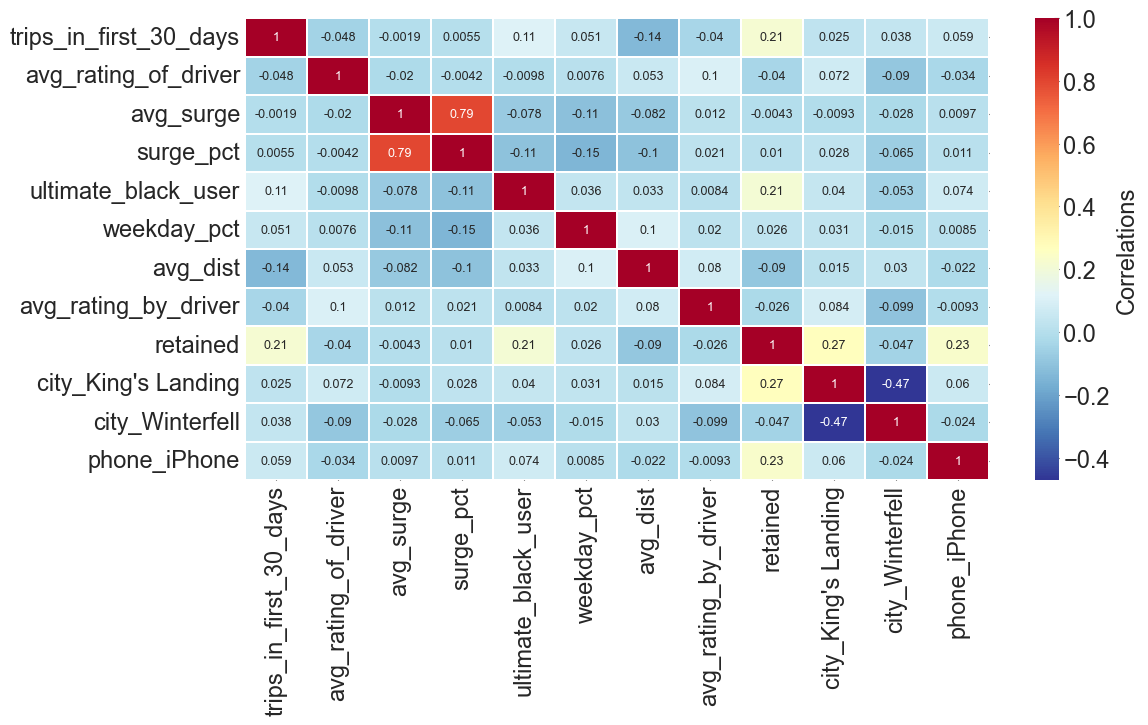

In [53]:
fig, ax = plt.subplots(figsize=(12,6))

sns.heatmap(corr, linewidth=.1, annot=True, annot_kws={"size":9}, cmap="RdYlBu_r", 
            cbar_kws={'label':'Correlations'}, ax=ax);

In [54]:
def calc_vif(X):
    ''' Calculating Variance Inflation Factor (VIF)
        args:
            X: input dataframe
        return:
            dataframe that contains VIF values
    '''
    vif = pd.DataFrame()
    vif["features"] = X.columns
    vif["VIFactor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

    return(vif)

In [55]:
vif = calc_vif(df)
vif.sort_values(by='VIFactor', ascending=False)

,features,VIFactor
7,avg_rating_by_driver,67.348605
1,avg_rating_of_driver,51.707811
2,avg_surge,50.025721
5,weekday_pct,3.799586
11,phone_iPhone,3.462596
3,surge_pct,2.882683
10,city_Winterfell,2.427808
6,avg_dist,2.161898
8,retained,1.970512
9,city_King's Landing,1.769716


In [56]:
df_final = df.drop(columns=['avg_rating_by_driver'])

In [57]:
vif = calc_vif(df_final)
vif.sort_values(by='VIFactor', ascending=False)

,features,VIFactor
2,avg_surge,38.042696
1,avg_rating_of_driver,31.979798
5,weekday_pct,3.765150
10,phone_iPhone,3.436674
3,surge_pct,2.600306
9,city_Winterfell,2.421386
6,avg_dist,2.146190
7,retained,1.970508
8,city_King's Landing,1.759755
4,ultimate_black_user,1.716530


In [58]:
df_final.drop(columns=['avg_surge'], inplace=True)

In [59]:
vif = calc_vif(df_final)
vif.sort_values(by='VIFactor', ascending=False)

,features,VIFactor
1,avg_rating_of_driver,8.566805
4,weekday_pct,3.706768
9,phone_iPhone,3.385117
8,city_Winterfell,2.367450
5,avg_dist,2.142513
6,retained,1.970018
7,city_King's Landing,1.759563
3,ultimate_black_user,1.710025
0,trips_in_first_30_days,1.459827
2,surge_pct,1.239400


> The maximum VIFactor is 8.5, which is marginally okay for assuming that all features in the data is not in multicollinearity.

In [60]:
corr = df_final.corr()

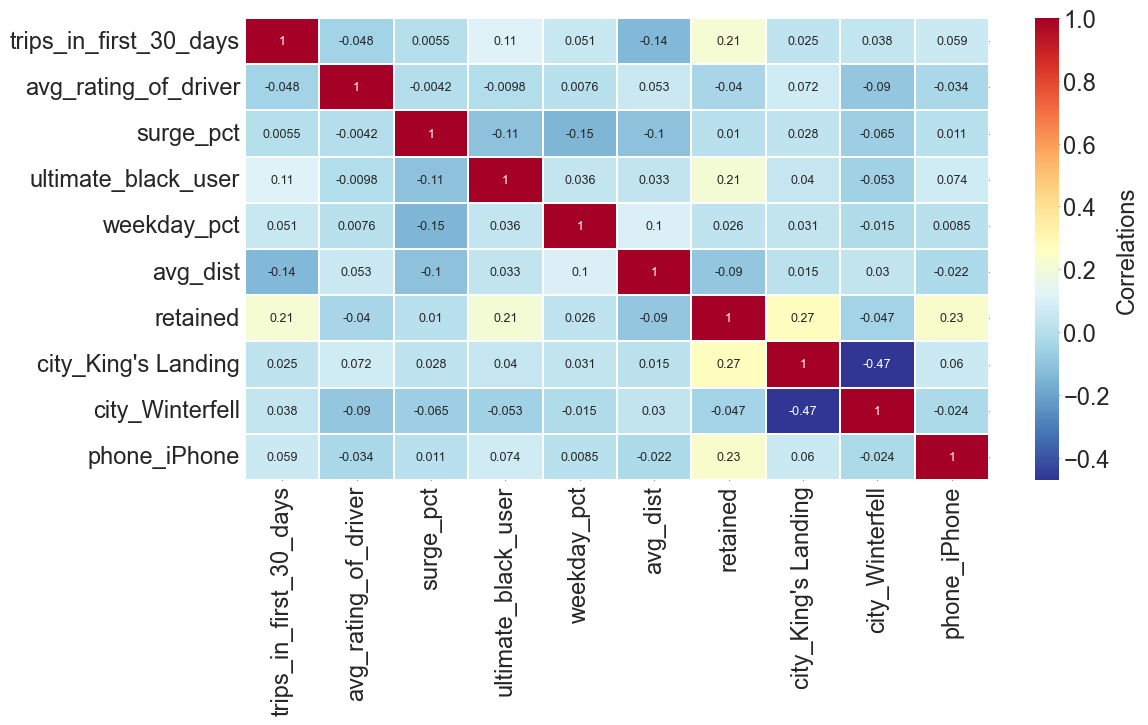

In [61]:
fig, ax = plt.subplots(figsize=(12,6))

sns.heatmap(corr, linewidth=.1, annot=True, annot_kws={"size":9}, cmap="RdYlBu_r", 
            cbar_kws={'label':'Correlations'}, ax=ax);

> Now the final dataset is ready for modeling.

### Split data into training and test sets

In [62]:
X = df_final.drop(columns=['retained'])
y = df_final.retained

In [63]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=23)

In [64]:
print('Shape of training set: {}'.format(X_train.shape))
print('Shape of test set: {}'.format(X_test.shape))

Shape of training set: (34722, 9)
Shape of test set: (14882, 9)


### Scaling

In [65]:
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

## Build a predictive model

### RandomForest: Hyperparameter tuning

In [67]:
model_randf = RandomForestClassifier(random_state=23)
kf = KFold(n_splits=6, shuffle=True, random_state=23)

# Create the parameter space
params = {'n_estimators': [int(x) for x in np.linspace(10,100,10)], # number of trees
          'criterion': ['gini', 'entropy'], # measure the quality of a split
          'max_features': ['auto', 'sqrt'], # The number of features to consider
          'max_depth': [2, 4, None], # maximum depth of the tree
          'min_samples_split': [2, 5], # minimum number of samples to split an internal node
          'min_samples_leaf': [1, 2], # minimum number of samples required to be a leaf node
          'bootstrap': [True, False]} # whether bootstrap samples are used when building trees

# Instantiate the RandomizedSearchCV object
randf_cv = RandomizedSearchCV(model_randf, params, cv=kf, scoring='roc_auc', error_score='raise')

# Fit the data to the model
randf_cv.fit(X_train_scaled, y_train)

# Print the tuned parameters and score
print("Tuned Random Forest Parameters:")
print(randf_cv.best_params_)
print("*"*30)
print("Tuned Random Forest Best Accuracy Score: {}".format(randf_cv.best_score_))

Tuned Random Forest Parameters:
{'n_estimators': 60, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 'auto', 'max_depth': None, 'criterion': 'entropy', 'bootstrap': True}
******************************
Tuned Random Forest Best Accuracy Score: 0.8282404943309087


### Build a model with best parameters

In [68]:
model_randf= RandomForestClassifier(random_state=23, **randf_cv.best_params_)

model_randf.fit(X_train_scaled, y_train)

RandomForestClassifier(criterion='entropy', min_samples_leaf=2,
                       min_samples_split=5, n_estimators=60, random_state=23)

In [69]:
# model predict
y_pred_randf = model_randf.predict(X_test_scaled)

# predict probabilities
y_pred_probs_randf = model_randf.predict_proba(X_test_scaled)[:,1]

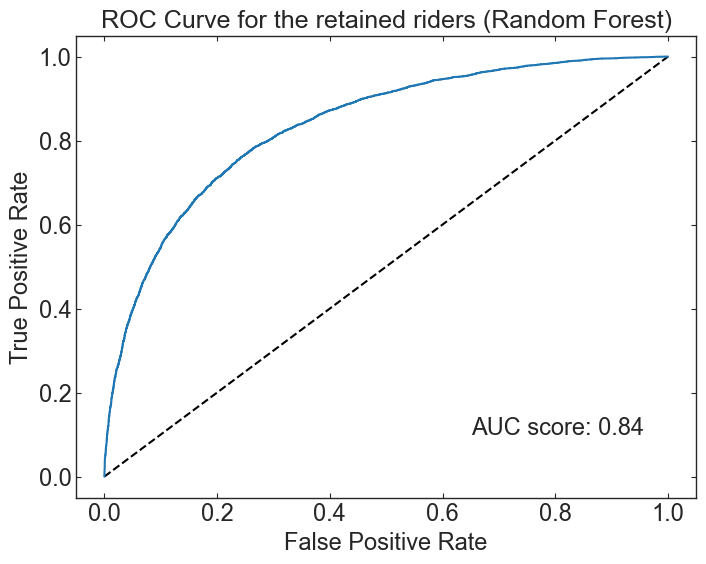

In [81]:
# Generate ROC curve values: fpr, tpr, thresholds
fpr_randf, tpr_randf, thresholds = roc_curve(y_test, y_pred_probs_randf)

fig, ax = plt.subplots()

ax.plot([0, 1], [0, 1], 'k--')
ax.plot(fpr_randf, tpr_randf)
ax.annotate('AUC score: {:.2f}'.format(roc_auc_score(y_test, y_pred_probs_randf)), \
           xy=(0.65,0.1), xycoords='data',ha='left')

ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('ROC Curve for the retained riders (Random Forest)', fontsize=18);

In [74]:
# Calculate roc_auc_score
randf_best_score = roc_auc_score(y_test, y_pred_probs_randf)
print("ROC AUC score: {:.2f}".format(randf_best_score))

# Calculate the confusion matrix
print("*"*10 + "  Confusion Matrix  " + "*"*10)
print(confusion_matrix(y_test, y_pred_randf))

# Calculate the classification report
print("*"*10 + "  Classification Report  " + "*"*10)
print(classification_report(y_test, y_pred_randf))

ROC AUC score: 0.84
**********  Confusion Matrix  **********
[[8026 1435]
 [1935 3486]]
**********  Classification Report  **********
              precision    recall  f1-score   support

           0       0.81      0.85      0.83      9461
           1       0.71      0.64      0.67      5421

    accuracy                           0.77     14882
   macro avg       0.76      0.75      0.75     14882
weighted avg       0.77      0.77      0.77     14882



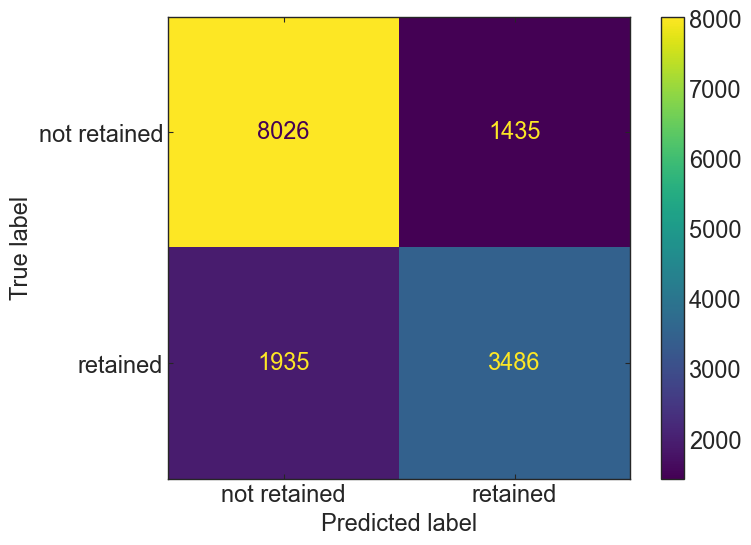

In [75]:
''' plot the confusion matrix '''
cm = confusion_matrix(y_test, y_pred_randf, labels = model_randf.classes_)
display_cm = ConfusionMatrixDisplay(confusion_matrix = cm, 
                                    display_labels = ['not retained', 'retained'])
fig, ax = plt.subplots()
display_cm.plot(ax=ax);

## Importance of features

In [93]:
fi_dict = {'feature':X.columns, 'Importance':model_randf.feature_importances_}
df_fi = pd.DataFrame(fi_dict)

df_fi = df_fi.sort_values(by='Importance', ascending=False)
df_fi

,feature,Importance
5,avg_dist,0.311897
4,weekday_pct,0.189623
2,surge_pct,0.129937
0,trips_in_first_30_days,0.100227
1,avg_rating_of_driver,0.092741
6,city_King's Landing,0.067930
8,phone_iPhone,0.050260
3,ultimate_black_user,0.038714
7,city_Winterfell,0.018671


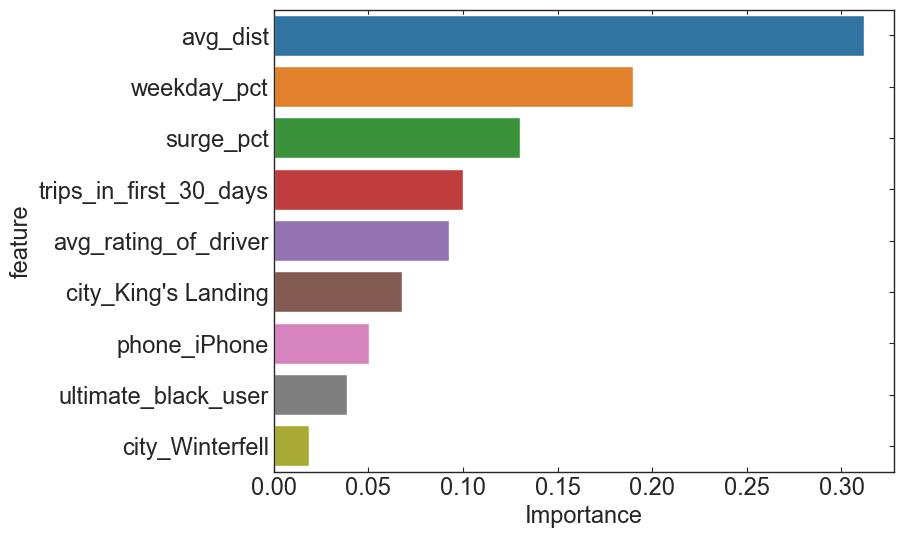

In [94]:
fig, ax = plt.subplots()

sns.barplot(x='Importance', y='feature', data=df_fi, ax=ax);

> Major features of importance are `avg_dist`, `weekday_pct`, and `surge_pct` from feature_importnaces of model.

### SHAP Analysis

In [97]:
# Fits the explainer
explainer = shap.Explainer(model_randf.predict, X_test_scaled)

# Calculates the SHAP values - It takes some time
shap_values = explainer(X_test_scaled)

# if only interested in the SHAP values: 
#shap_values = explainer.shap_values(X_test_scaled)

# rename the features (since the feature names were removed in the scaled data)
shap_values.feature_names = X_test.columns.values.tolist()

Exact explainer: 14883it [45:41,  5.41it/s]                                                                                     


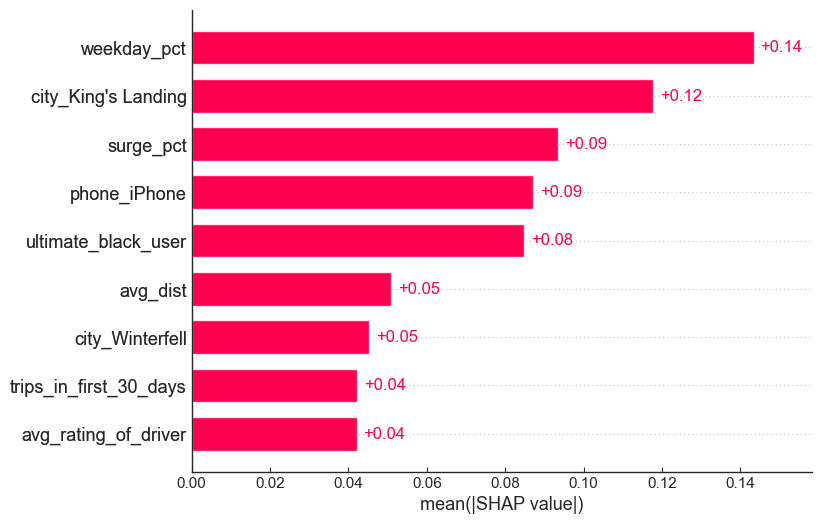

In [99]:
shap.plots.bar(shap_values);

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


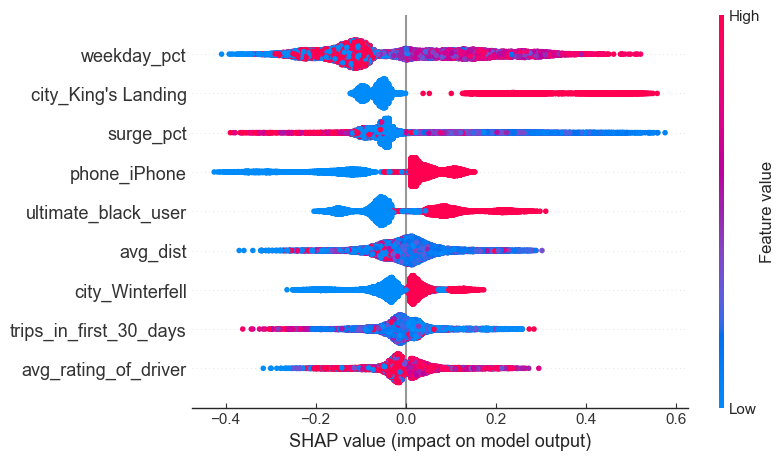

In [100]:
shap.plots.beeswarm(shap_values);

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


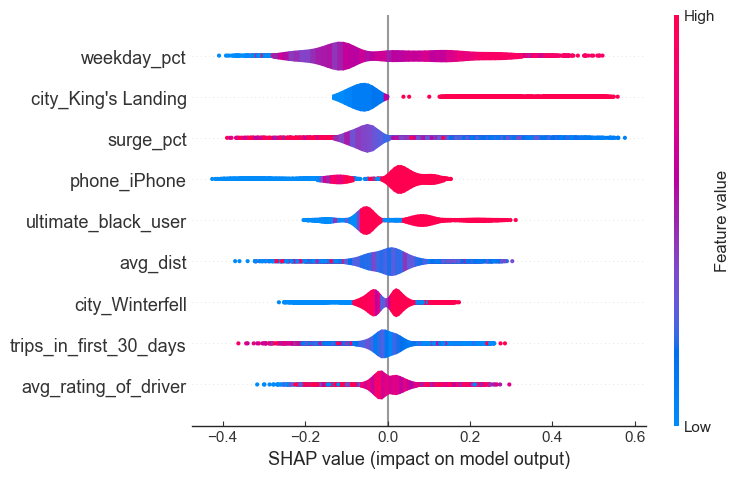

In [101]:
shap.summary_plot(shap_values, plot_type='violin');

> The results from Shap analysis is slightly different from feature_importances above. The high rank features in Shap analysis are `weekday_pct`, `city_King's Landing`, and `surge_pct`.
> - However, we could see that overall, `weekday_pct`, `surge_pct`, `avg_dist` can be considered as important features.
> - lower `surge_pct` results in higher shap value, implying more retiontion.

### Suggestions for long-term rider retention

To improve long-term rider retention, we suggest Ultimate to consider
- suggest riders to take trips more during weekdays.
- recommend riders to reduce the increase surge price during holidays.
- recommend riders to take longer trips during the first 30 days after signup.